In [1]:
# Grundlegende Bibliotheken
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import numpy as np
import missingno as msno

# Einstellungen für bessere Plots
plt.rcParams['figure.figsize'] = (10, 6)

# Pandas Optionen
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Download latest version


path = kagglehub.dataset_download("priyamchoksi/credit-card-transactions-dataset")

ds = pd.read_csv(f"{path}/credit_card_transactions.csv")

print(f"Anzahl Zeilen: {ds.shape[0]}")
print(f"Anzahl Spalten: {ds.shape[1]}")

Anzahl Zeilen: 1296675
Anzahl Spalten: 24


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

y = ds["is_fraud"]
X = ds[["trans_date_trans_time", "merchant", "category", "amt", "state", "job", "dob"]]

# Datenvorbereitung
X["trans_date_trans_time"] = pd.to_datetime(X["trans_date_trans_time"])
X["dob"] = pd.to_datetime(X["dob"])

X["trans_year"] = X["trans_date_trans_time"].dt.year
X["trans_month"] = X["trans_date_trans_time"].dt.month
X["trans_day"] = X["trans_date_trans_time"].dt.day
X["trans_hour"] = X["trans_date_trans_time"].dt.hour

X["birth_year"] = X["dob"].dt.year
X["age"] = X["trans_year"] - X["birth_year"]

X = X.drop(columns=["trans_date_trans_time", "dob"])

categorical_features = ["merchant", "category", "state", "job"]
numeric_features = ["amt", "trans_year", "trans_month", "trans_day", "trans_hour", "age"]

# One-Hot-Encoding
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ],
    remainder="passthrough"  # lässt numerische Spalten unverändert
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_51496/2506800533.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["trans_date_trans_time"] = pd.to_datetime(X["trans_date_trans_time"])
/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_51496/2506800533.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["dob"] = pd.to_datetime(X["dob"])
/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_51496/2506800533.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy 

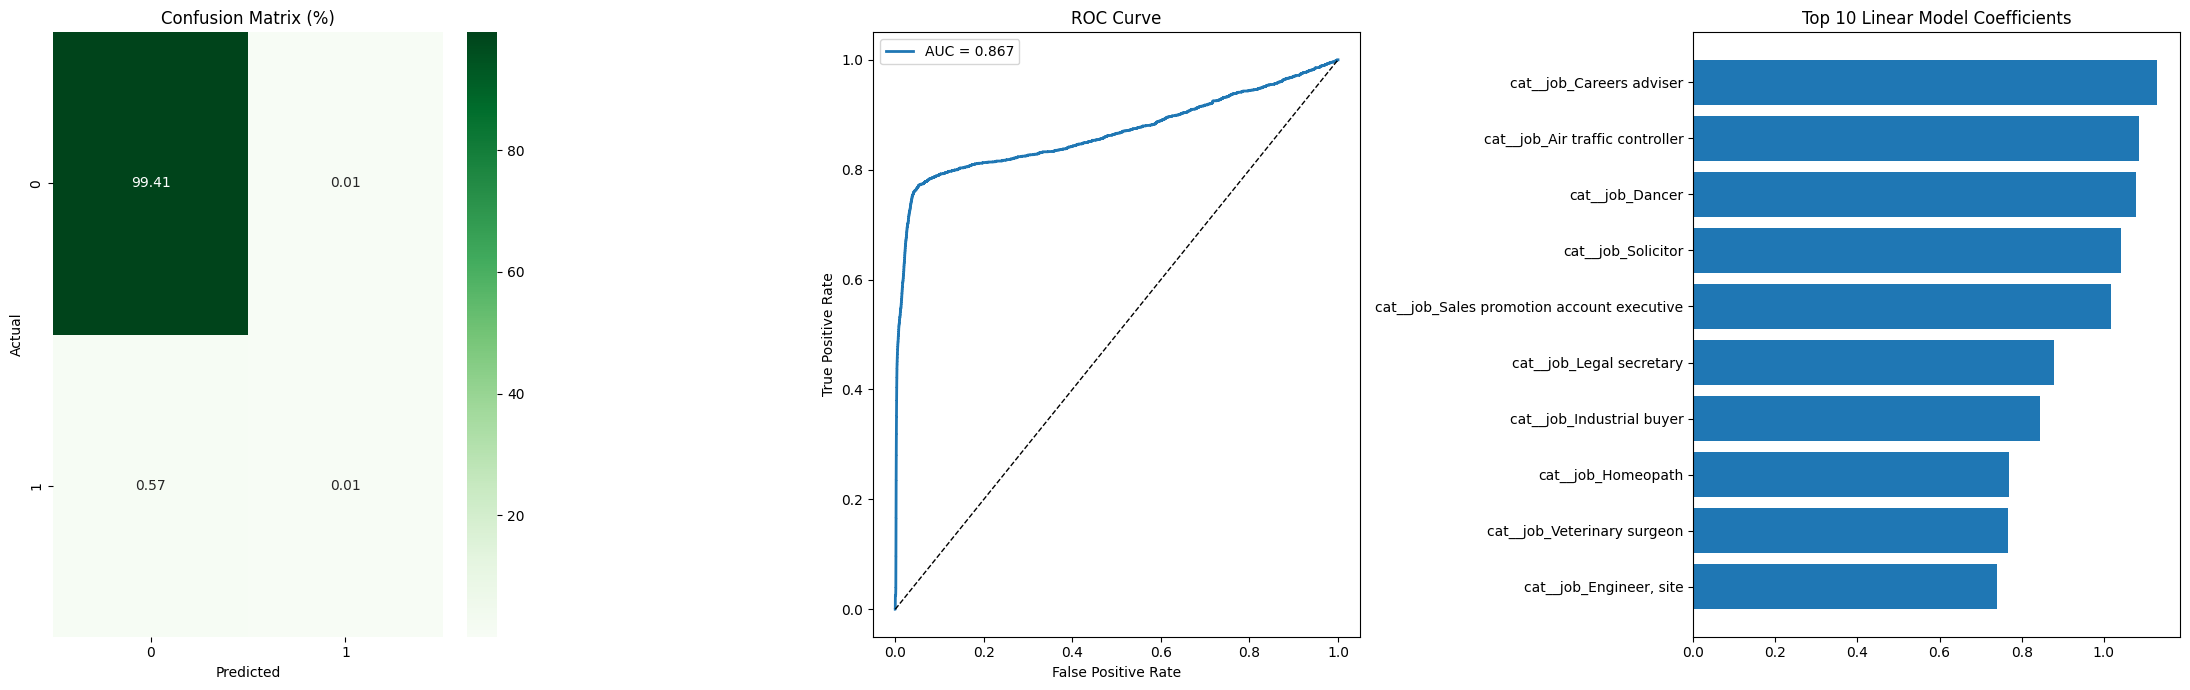

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# -----------------------------
# 1️⃣ Prediction + Thresholding
# -----------------------------
y_prob = model.predict(X_test)                   # continuous output
y_pred = (y_prob >= 0.5).astype(int)             # convert to class labels

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype("float") / cm.sum() * 100

# -----------------------------
# 2️⃣ ROC Curve Daten
# -----------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

# -----------------------------
# 3️⃣ Feature Importance (Regression Coefficients)
# -----------------------------
feature_names = model.named_steps["preprocessor"].get_feature_names_out()
coef = model.named_steps["classifier"].coef_

feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coef
})

# sort by absolute weight
feat_imp = feat_imp.reindex(feat_imp.Coefficient.abs().sort_values(ascending=False).index)
top_feat = feat_imp.head(10)

# -----------------------------
# 4️⃣ Figure mit 3 Subplots
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

# --- Confusion Matrix ---
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Greens", ax=axes[0])
axes[0].set_title("Confusion Matrix (%)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# --- ROC Kurve ---
axes[1].plot(fpr, tpr, label=f"AUC = {auc_score:.3f}", linewidth=2)
axes[1].plot([0,1], [0,1], "k--", linewidth=1)
axes[1].set_title("ROC Curve")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend()

# --- Feature Importance ---
axes[2].barh(top_feat["Feature"], top_feat["Coefficient"])
axes[2].invert_yaxis()
axes[2].set_title("Top 10 Linear Model Coefficients")

plt.tight_layout()
plt.show()